In [52]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 导包和加载模型

In [53]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [54]:
# epsilons = [0, 1/255, 10/255, 20/255, 50/255]
epsilons = [1/255, 10/255, 20/255, 50/255]
n_epochs = 5
# pretrained_model = "./param.pth"
pretrained_model = "/content/drive/MyDrive/Colab Notebooks/model/param.pth"

In [55]:
torch.cuda.is_available()

True

In [56]:
#net
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        # 卷积层1
        self.conv1 = nn.Conv2d(in_channels = 1 , out_channels = 32, kernel_size = 5, stride = 1, padding = 0 )
        # 对每个通道的数据进行归一化
        self.batch1 = nn.BatchNorm2d(32)
        # ReLu激活函数
        self.relu1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(in_channels =32 , out_channels = 32, kernel_size = 5, stride = 1, padding = 0 )
        self.batch2 = nn.BatchNorm2d(32)
        self.relu2 = nn.ReLU()
        # 最大池化
        self.maxpool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        # Dropout防止过拟合
        self.conv1_drop = nn.Dropout(0.25)

        # 卷积层2
        self.conv3 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, stride = 1, padding = 0 )
        self.batch3 = nn.BatchNorm2d(64)
        self.relu3 = nn.ReLU()
        
        self.conv4 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, stride = 1, padding = 0 )
        self.batch4 = nn.BatchNorm2d(64)
        self.relu4 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.conv2_drop = nn.Dropout(0.25)

        # 全连接层1
        
        self.fc1 = nn.Linear(576,256)
        self.fc1_relu = nn.ReLU()
        self.dp1 = nn.Dropout(0.5)
        
        # 全连接层2
        self.fc2 = nn.Linear(256,10)
                
    def forward(self, x):
        # 卷积层1的前向计算
        # print(out.shape)
        # (batch_size,1,28,28)

        out = self.conv1(x)
        out = self.relu1(out)
        out = self.batch1(out)
        # print(out.shape)
        # (batch_size,32,24,24)

        out = self.conv2(out)
        out = self.relu2(out)
        out = self.batch2(out)
        # print(out.shape)
        # (batch_size,32,20,20)

        out = self.maxpool1(out)
        out = self.conv1_drop(out)
        # print(out.shape)
        # (batch_size,32,10,10)

        # 卷积层2的前向计算
        out = self.conv3(out)
        out = self.relu3(out)
        out = self.batch3(out)
        # print(out.shape)        
        # (batch_size,64,8,8)

        out = self.conv4(out)
        out = self.relu4(out)
        out = self.batch4(out)   
        # print(out.shape)
        # (batch_size,64,6,6)

        out = self.maxpool2(out)
        out = self.conv2_drop(out)
        # print(out.shape)
        # (batch_size,64,3,3)

        # Flatten拉平操作
        out = out.view(out.size(0),-1)
        # print(out.shape)
        # (batch_size,576)
        
        # 全连接层的前向计算
        out = self.fc1(out)
        out = self.fc1_relu(out)
        out = self.dp1(out)
        # print(out.shape)
        # (batch_size,256)

        out = self.fc2(out)
        # print(out.shape)
        # (batch_size,10)

        return F.log_softmax(out,dim = 1)

In [57]:
# MNIST Test dataset and dataloader declaration
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
            ])), 
        batch_size=1, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [58]:
# Initialize the network
model = CNNModel().to(device)

# Load the pretrained model
model.load_state_dict(torch.load(pretrained_model, map_location='cpu')) # 加载模型的参数
# model = torch.load(pretrained_model)  # 加载整个模型及其参数

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

CNNModel(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (batch1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (batch2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1_drop): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (batch3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (batch4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2_drop): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=576, ou

## FGSM攻击

In [59]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    
#     print(image)
    perturbed_image = image - epsilon*sign_data_grad
#     print(perturbed_image)
    
    # Adding clipping to maintain [0,1] range
    # perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # 在(0,1)用torch.clamp会和前面DataLoader()中的Normalize((0.1307,), (0.3081,))有冲突，干脆不用

    # Return the perturbed image
    return perturbed_image.detach()

In [60]:
def test( model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    succ = 0
    adv_examples = []

    tag = [0] * 10

    # Loop over all examples in test set
    for batch_idx, (data, target) in enumerate(test_loader):
        # 保存原始图像以供对比
        origData = data

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # 如果模型最初预测就是错的，就不再攻击这个样本了
        if init_pred.item() != target.item():
            continue

        for epoch in range(1, n_epochs + 1):    
        
            # 计算损失
            loss = F.nll_loss(output, (target+1)%10)

            # 归零梯度
            model.zero_grad()

            # Calculate gradients of model in backward pass
            loss.backward()

            # Collect datagrad
#             print(data)
            data_grad = data.grad.data

            # Call FGSM Attack
            perturbed_data = fgsm_attack(data, epsilon, data_grad)
            data = perturbed_data
            data.requires_grad = True        
        
            # 迭代过程中的攻击结果
            output = model(data)
            # init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

            print('\r\t Adversarial Attack Epoch: [{}/{} ({:.0f}%)]\t'.format(
                 (batch_idx + 1) * len(data), len(test_loader.dataset),
                100. * batch_idx / len(test_loader)),end = '')


        # Re-classify the perturbed image
        output = model(perturbed_data)

        # print(output)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
        else:
            # 保存结果图以便后续可视化
            if len(adv_examples) < 20 and init_pred.item()!=final_pred.item() :
                if tag[init_pred.item()] == 0 and final_pred.item()==((init_pred.item()+1)%10) :
                    # print("\r 最初预测值：{} 攻击后预测值：{}".format(init_pred.item(),final_pred.item()))
                    tag[init_pred.item()] = 1
                    adv_ex = origData.squeeze().detach().cpu().numpy()
                    adv_examples.append( (init_pred.item(), -1, adv_ex) )
                    adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                    adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
            if final_pred.item()==((init_pred.item()+1)%10):
                succ += 1

    # 计算当前epsilon的准确率
    final_acc = correct/float(len(test_loader))
    print("\n\t Test Accuracy = {} / {} = {}".format(correct, len(test_loader), final_acc))
    print("\t 本轮攻击success个数：{}".format(succ))

    success.append(succ)

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [61]:
accuracies = []    # 储存每个epsilon被攻击后的模型的准确率
success = []     # 储存每个epsilon攻击成功的样本个数
examples = []

# Run test for each epsilon
for eps in epsilons:
    print("Epsilons = {:.3f}:".format(eps))
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilons = 0.004:
	 Adversarial Attack Epoch: [10000/10000 (100%)]	
	 Test Accuracy = 9942 / 10000 = 0.9942
	 本轮攻击success个数：5
Epsilons = 0.039:
	 Adversarial Attack Epoch: [10000/10000 (100%)]	
	 Test Accuracy = 7368 / 10000 = 0.7368
	 本轮攻击success个数：1637
Epsilons = 0.078:
	 Adversarial Attack Epoch: [10000/10000 (100%)]	
	 Test Accuracy = 2529 / 10000 = 0.2529
	 本轮攻击success个数：4835
Epsilons = 0.196:
	 Adversarial Attack Epoch: [10000/10000 (100%)]	
	 Test Accuracy = 63 / 10000 = 0.0063
	 本轮攻击success个数：9483


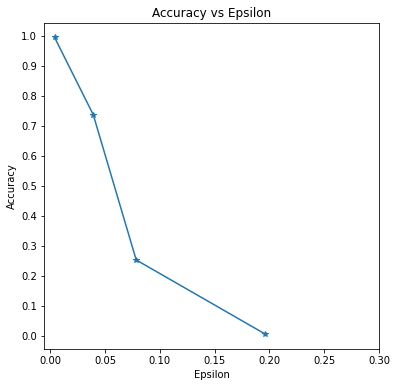

In [62]:
plt.figure(figsize=(6,6))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

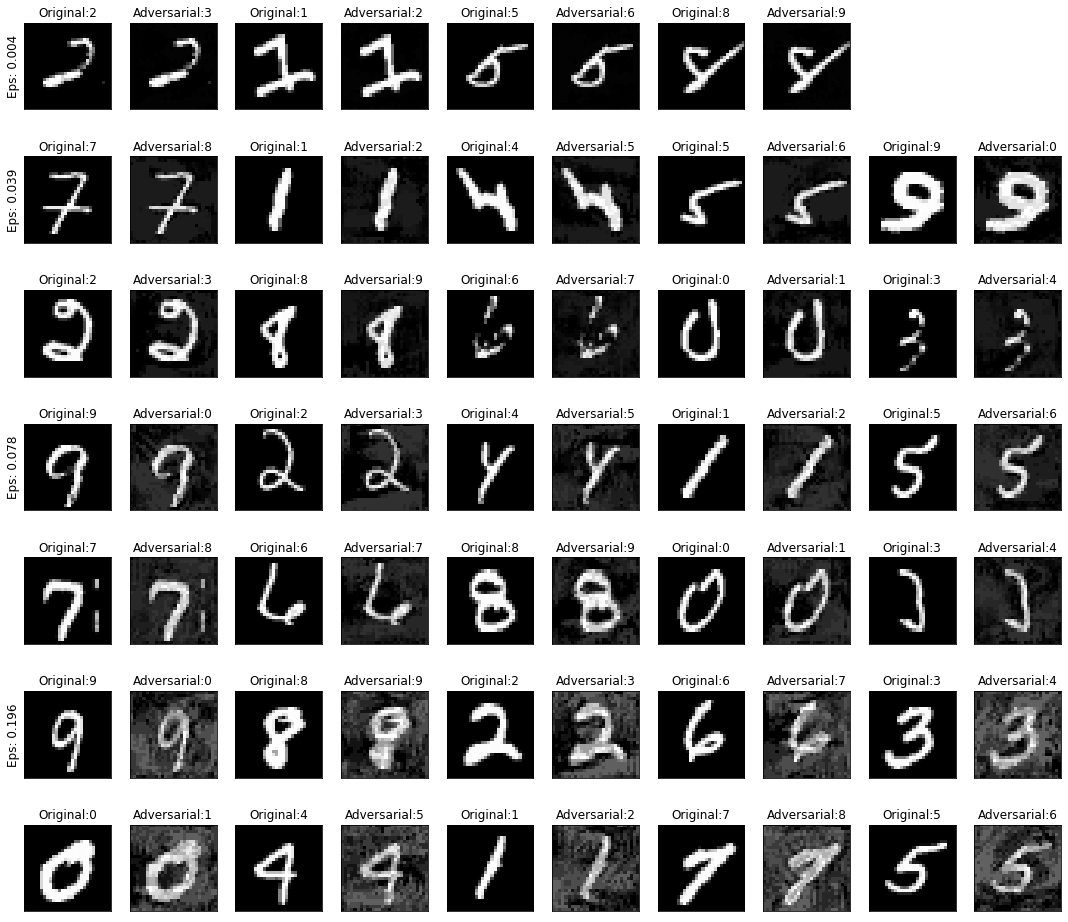

In [63]:
# Plot several examples of adversarial samples at each epsilon
cnt = 1
plt.figure(figsize=(15,15))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        if j == 0:
            while cnt%10 != 1:
                cnt+=1
        plt.subplot(len(epsilons)*2,10,cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {:.3f}".format(epsilons[i]), fontsize=12)
        orig,adv,ex = examples[i][j]
        if j%2 == 0:
            plt.title("Original:{}".format(orig))
        else:
            plt.title("Adversarial:{}".format(adv))
        plt.imshow(ex, cmap="gray")
        cnt += 1
plt.tight_layout()
plt.show()

- epsilons = [1/255, 10/255, 20/255, 50/255]

  上述四个不同的$\epsilon$取值时，**定向攻击成功**的部分样本图已经展示如上

- 我对原测试集样本进行了**5**轮攻击迭代

  epsilons = **1/255**时，仅有1、2、5、8四类数字攻击成功

  epsilons = **10/255**、 **20/255** 和 **50/255** 时，10个数字都有攻击成功的样本

- 在四个取值下进行对抗攻击后，模型的准确率分别从99.52%降低到了[ 99.42%, 73.68%, 25.29%, 0.63% ]


In [64]:
accuracies

[0.9942, 0.7368, 0.2529, 0.0063]

In [65]:
success

[5, 1637, 4835, 9483]

## 攻击成功率计算

按照$$攻击成功率=成功次数÷攻击次数$$的公式

由于只攻击了**原模型能够正确预测**的样本，即Epsilon=0时正确的个数，故 **攻击次数**=9952×5（即**每张样本图迭代5次视作攻击5次**）

四个Epsilon取值下，**成功次数【记原本预测正确，攻击后预测为(target+1)%10为攻击成功】**分别为：9952-9942, 9952-7368, 9952-2529, 9952-63

故四个取值下成功率分别为：10/(9952×5)×100%, 2584/(9952×5)×100%, 7423/(9952×5)×100%, 9889/(9952×5)×100%

其值如下所示


In [66]:
success_rate = []
sr0 = 0.9952
for i in range(len(accuracies)):
    success_rate.append((success[i]/100)/sr0/5)
    print(success_rate[i])

0.01004823151125402
3.2897909967845664
9.716639871382636
19.057475884244376


即四个Epsilon取值和对应的攻击成功率如下表所示：

| Epsilon | SuccessRate |
| ------- | ----------- |
| 1/255   | 0.01%       |
| 10/255  | 3.29%       |
| 20/255  | 9.72%       |
| 50/255  | 19.06%      |

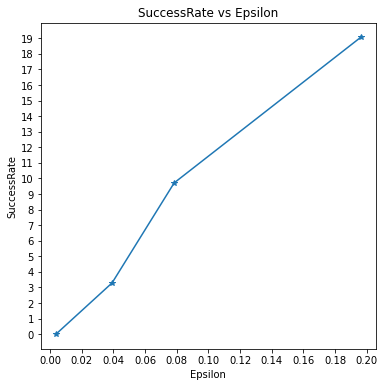

In [67]:
plt.figure(figsize=(6,6))
# epsilons = [0, 1/255, 10/255, 20/255, 50/255]
# success_rate[0] = 0
plt.plot(epsilons, success_rate, "*-")
plt.yticks(np.arange(0, 20, step=1))
plt.xticks(np.arange(0, 0.22, step=0.02))
plt.title("SuccessRate vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("SuccessRate")
plt.show()

## 选取Epsilon=10/255的结果进行展示

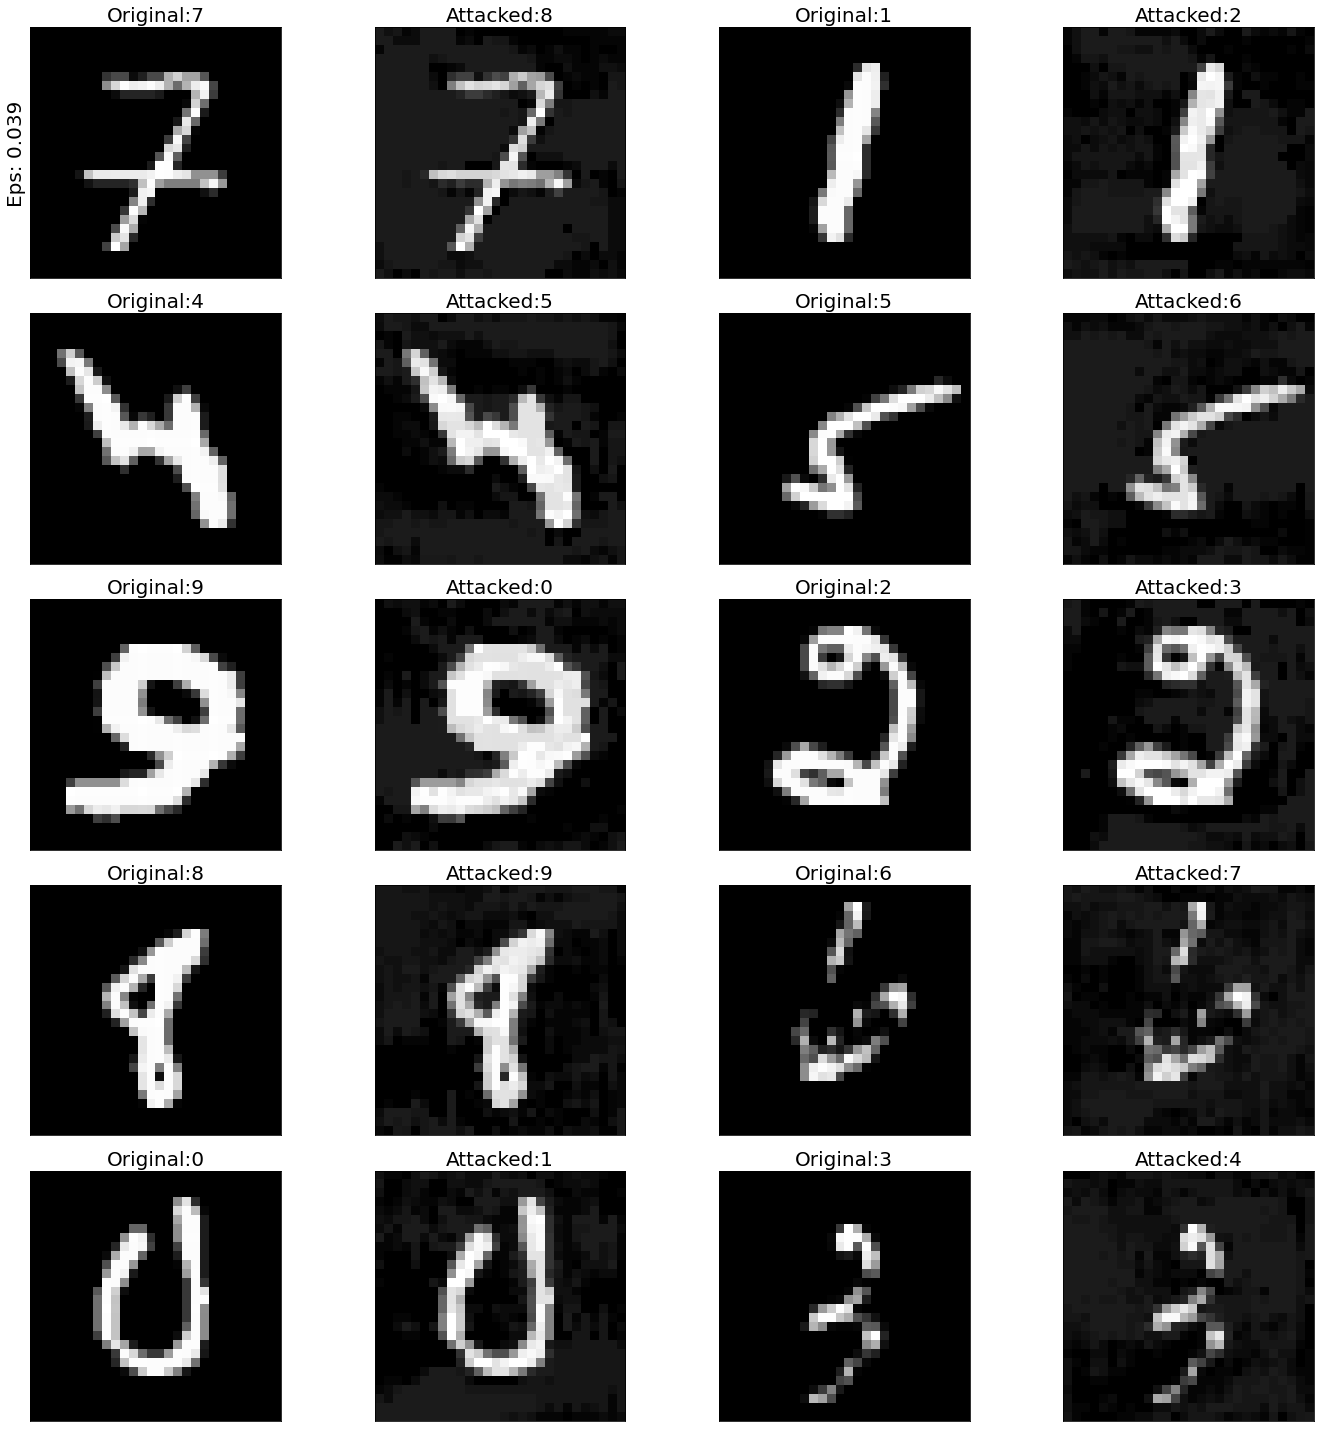

In [68]:
# Plot several examples of adversarial samples at each epsilon
cnt = 1
plt.figure(figsize=(20,20))

for j in range(len(examples[1])):
    if j == 0:
        while cnt%10 != 1:
            cnt+=1
    plt.subplot(5,4,cnt)
    plt.xticks([], [])
    plt.yticks([], [])
    if j == 0:
        plt.ylabel("Eps: {:.3f}".format(epsilons[1]), fontsize=20)
    orig,adv,ex = examples[1][j]
    if j%2 == 0:
        plt.title("Original:{}".format(orig), fontsize=20)
    else:
        plt.title("Attacked:{}".format(adv), fontsize=20)
    plt.imshow(ex, cmap="gray")
    cnt += 1
plt.tight_layout()
plt.show()

上面的5行4列的图，表示  **Epsilon=10/255**  时的结果对比图

选取Epsilon=10/255是想在Epsilon的取值尽可能低的前提下凑齐十个数字都攻击成功的样本，这样攻击痕迹也并不明显，难以被肉眼发现

Original表示原图和未攻击时的预测结果

Attacked表示攻击后的图片和攻击后的预测结果

共20张子图，包含了10类数字的示例图片

## reference
- [探索loss.backward() 和optimizer.step()的关系并灵活运用](https://blog.csdn.net/weixin_45180140/article/details/122047545)
- [pytorch之model.zero_grad() 与 optimizer.zero_grad()](https://blog.csdn.net/ltochange/article/details/116590485)
- [leaf Variable、requires_grad、grad_fn的含义以及它们之间的关系](https://blog.csdn.net/a1367666195/article/details/105654101)
- [Pytorch中requires_grad_(), detach(), torch.no_grad()的区别](https://www.jianshu.com/p/ff74ccae25f3)
- [解决对一个对象多次BP更新时造成的RuntimeError: you can only change requires_grad flags of leaf variables.问题](https://blog.csdn.net/xjtu_yyl/article/details/120594713)